In [1]:
from elk import catalogue

In [2]:
total_mass = 60
imr_cat = catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95.)
seo_cat = catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95.)

In [3]:
catalogue = catalogue.NRCatalogue(origin="GeorgiaTech")

In [4]:
spin_free = catalogue.spin_free()

In [5]:
query_table = catalogue.table.query( "spin_1x == 0 & spin_1y == 0 & spin_1z == 0"
            " & spin_2x == 0 & spin_2y == 0 & spin_2z == 0")

In [6]:
 query_waveforms = [waveform for waveform in catalogue.waveforms if waveform.tag in list(query_table['tag'])]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


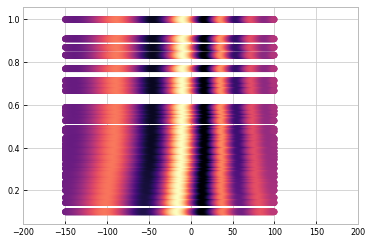

In [8]:
for waveform in query_waveforms:
    p = {"mass ratio": waveform.mass_ratio,
                 "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                 "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z}
    ts = seo_cat.waveform(p=p, time_range=[-150., 100., 1024], coa_phase=0)[0]
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    plt.xlim([-200, 200])

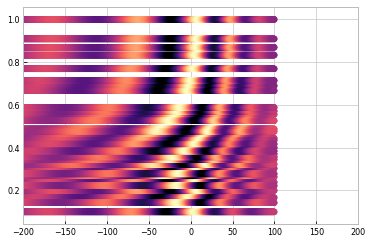

In [13]:
for waveform in query_waveforms:
    p = {"mass ratio": waveform.mass_ratio,
                 "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                 "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z}
    ts = imr_cat.waveform(p=p, time_range=[-250., 100., 1024], coa_phase=0, f_ref=500)[0]
    #ts.times -= ts.times[np.argmax((ts.data))]
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    plt.xlim([-200, 200])

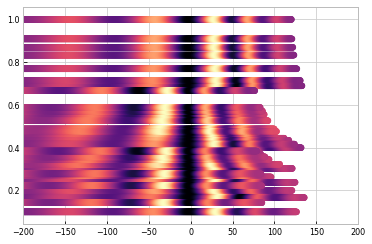

In [9]:
for waveform in query_waveforms:
    p = {"mass ratio": waveform.mass_ratio,
                 "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                 "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z}
    ts = imr_cat.waveform(p=p, time_range=[-250., 100., 1024], coa_phase=0, f_ref=500)[0]
    ts.times -= ts.times[np.argmax((ts.data))]
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    plt.xlim([-200, 200])

In [28]:
from pycbc.waveform import get_fd_waveform_from_td, get_fd_waveform, get_td_waveform

In [ ]:
approximant=self.approximant,
                                 mass1=mass1,
                                 mass2=mass2,
                                 spin1x=p['spin 1x'],
                                 spin1y=p['spin 1y'],
                                 spin1z=p['spin 1z'],
                                 spin2x=p['spin 2x'],
                                 spin2y=p['spin 2y'],
                                 spin2z=p['spin 2z'],
                                 distance=distance,
                                 delta_t=delta_t/1e4,
                                 coa_phase=coa_phase,
                                 f_ref=f_ref,
                                 f_lower=self.fmin

## IMRPhenomPv2 

First, the time versus mass-ratio plot, with no attempt to align the waveforms at some specific time.

In [92]:
waveforms = []
mrs = np.linspace(1., 12., 47)
for mass_ratio in mrs:
    
    total_mass = 60.0
    mass_2 = (total_mass/(mass_ratio + 1.))
    mass_1 = total_mass - mass_2
    waveforms.append(get_td_waveform(approximant="IMRPhenomPv2", 
                                     mass1=mass_1, mass2=mass_2, 
                                     f_ref=1000,
                                     delta_t=1./8192, f_lower=100))


(-0.05, 0.01)

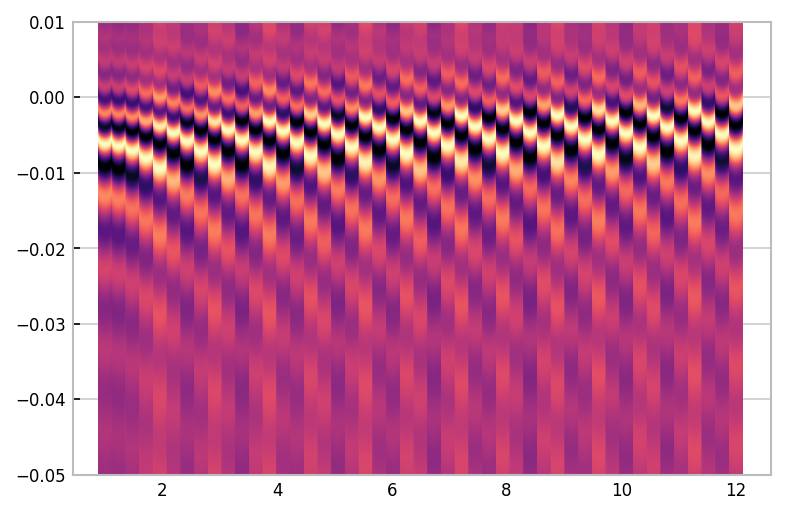

In [93]:
f, ax = plt.subplots(1,1, dpi=150)
for mr, waveform in zip(mrs, waveforms):
    wave = waveform[0].trim_zeros()
    ax.scatter(mr*np.ones(len(wave.sample_times)), wave.sample_times, c = wave.data)
ax.set_ylim(-0.05, 0.01)

In [135]:
import h5py
import lal
import lalsimulation as lalsim

In [136]:
def read_flow(h5path_new):
    
    h5file = h5py.File(h5path_new)

    for item in h5file.attrs.keys():
        if (item=='f_lower_at_1MSUN'):
            return h5file.attrs[item]
    h5file.close()

In [141]:
def set_mode_in_params(params, l, m):
    """ Sets modes in params dict.
        Only adds (l,m) and (l,-m) modes.
    """

    ma=lalsim.SimInspiralCreateModeArray()

    lalsim.SimInspiralModeArrayActivateMode(ma, l, m)
    lalsim.SimInspiralModeArrayActivateMode(ma, l, -m)
    lalsim.SimInspiralWaveformParamsInsertModeArray(params, ma)
    return params


In [146]:
def load_lvcnr_data(filepath, mode):
    """ Loads only (l,m) and (l,-m) modes of lvcnr data
    """

    with h5py.File(filepath) as NRh5File:
        # set mode for NR data
        params_NR = lal.CreateDict()
        lalsim.SimInspiralWaveformParamsInsertNumRelData(params_NR, filepath)
        params_NR = set_mode_in_params(params_NR, mode[0], mode[1])
        mtotal = 100.
        deltaT = 1./4096. #1.0/8192.
        m1 = NRh5File.attrs['mass1']
        m2 = NRh5File.attrs['mass2']
        m1SI = m1 * mtotal/(m1 + m2) * lal.MSUN_SI #Assumes masses are irreducible masses
        m2SI = m2 * mtotal/(m1 + m2) * lal.MSUN_SI

        # This will use the entire data
        f_lower = 0

        inclination = 0
        distance = 100. * lal.PC_SI * 1.0e6
        phiRef = 0.0
        fRef = f_lower
        spins = lalsim.SimInspiralNRWaveformGetSpinsFromHDF5File(fRef, mtotal, filepath)
        s1x = spins[0]
        s1y = spins[1]
        s1z = spins[2]
        s2x = spins[3]
        s2y = spins[4]
        s2z = spins[5]


        # If f_lower == 0, update it to the start frequency so that SEOBNRv4 gets the right start
        # frequency
        if f_lower == 0:
            f_lower = NRh5File.attrs['f_lower_at_1MSUN']/mtotal
        fRef = f_lower
        fStart = fRef
        approx = lalsim.NR_hdf5
        hp, hc = lalsim.SimInspiralChooseTDWaveform(m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, 0.0, 0.0, 0.0, deltaT, fStart, fRef, params_NR, approx)
        times = np.arange(len(hp.data.data))*hp.deltaT
        return times, hp, hc, mtotal, m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, deltaT, fStart, fRef



In [149]:
waveforms = []
mrs = np.array(query_table.mass_ratio)
tags = np.array(query_table['tag'])
for tag, mr in zip(tags, mrs):
    wavefile = "/home/daniel/data-nosync/lvcnr-lfs/GeorgiaTech/{}.h5".format(tag)
    #NRh5File = h5py.File(wavefile, 'r')
    t_NR, hp_NR, hc_NR, mtotal, m1SI, m2SI, s1x, s1y, s1z, s2x, s2y, s2z, distance, inclination, phiRef, deltaT, fStart, fRef = load_lvcnr_data(wavefile, [2,2])
    #NRh5File.close()
    flow_metadata = read_flow(wavefile)
    total_mass = 60.0
    mass_ratio = 1.0/mr
    mass_2 = (total_mass/(mass_ratio + 1.))
    mass_1 = total_mass - mass_2
    waveforms.append(get_td_waveform(approximant="NR_hdf5", 
                                     mass1=mass_1, mass2=mass_2, 
                                     f_ref=0,
                                     numrel_data=wavefile, 
                                     delta_t=1./8192, f_lower=100))

RuntimeError: I/O error

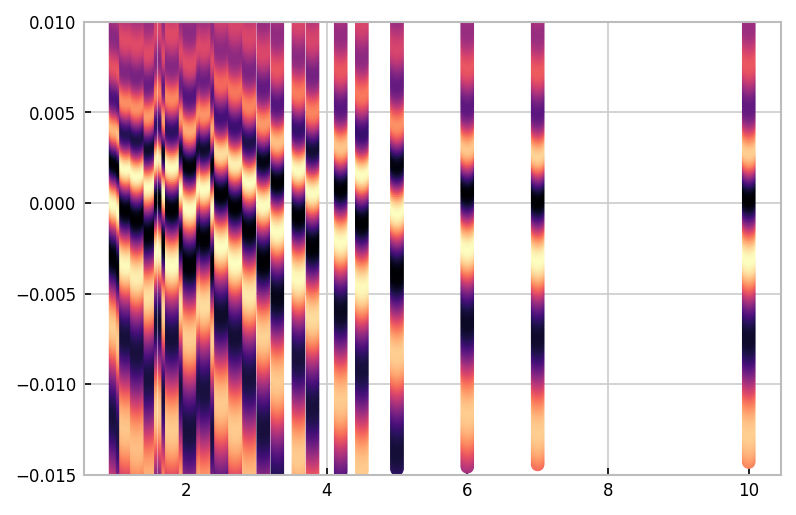

In [123]:
f, ax = plt.subplots(1,1, dpi=150)
for mr, waveform in zip(mrs, waveforms):
    wave = waveform[0].trim_zeros()
    ax.scatter(1./mr*np.ones(len(wave.sample_times)), wave.sample_times, c = wave.data)
    
    ax.set_ylim([-.015, .01])

(-0.02, 0.01)

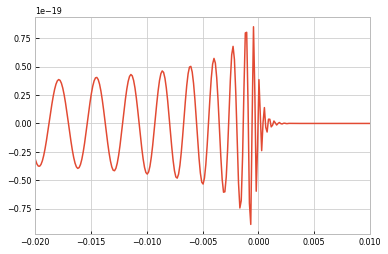

In [42]:
f, ax = plt.subplots(1,1)
ax.plot(fd[0].sample_times, fd[0].data)
ax.set_xlim([-0.02, 0.01])

(-200, 200)

/home/daniel/.virtualenvs/IGRlaptop21/heron-stable/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u"'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


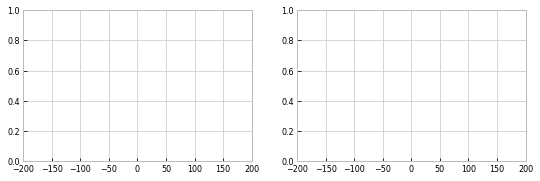

In [9]:
width = 4.5
height = width/1.618
f, ax = plt.subplots(1,2, figsize=(2*width, height));
for waveform in query_waveforms:
    p = {"mass ratio": waveform.mass_ratio,
                 "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                 "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z}
    ts = imr_cat.waveform(p=p, time_range=[-250., 100., 1024], coa_phase=0.5)[0]
    #ts.times -= ts.times[np.argmax((ts.data))]
    ax[0].scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    
    
    ts = waveform.timeseries(60, flow=95, sample_rate=4096)[0]
    #ts.times -= ts.times[np.argmin((ts.data))]
    ax[1].scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)

ax[0].set_xlim([-200, 200])
ax[1].set_xlim([-200, 200])

(-200, 200)

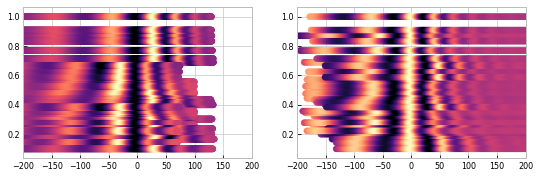

In [18]:
width = 4.5
height = width/1.618
f, ax = plt.subplots(1,2, figsize=(2*width, height));
for waveform in query_waveforms:
    p = {"mass ratio": waveform.mass_ratio,
                 "spin 1x": waveform.spin_1x, "spin 1y": waveform.spin_1y, "spin 1z": waveform.spin_1z,
                 "spin 2x": waveform.spin_2x, "spin 2y": waveform.spin_2y, "spin 2z": waveform.spin_2z}
    ts = imr_cat.waveform(p=p, time_range=[-250., 100., 1024], coa_phase=0)[0]
    ts.times -= ts.times[np.argmax((ts.data))]
    ax[0].scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    
    
    ts = waveform.timeseries(60, flow=95, sample_rate=4096, ma=[[2,2]])[0]
    ts.times -= ts.times[np.argmin((ts.data))]
    ax[1].scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)

ax[0].set_xlim([-200, 200])
ax[1].set_xlim([-200, 200])

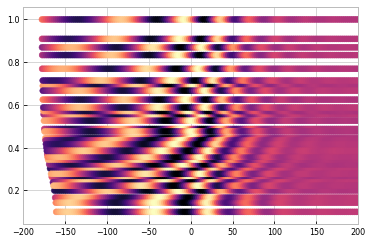

In [19]:
for waveform in query_waveforms:
    ts = waveform.timeseries(60, flow=95, sample_rate=4096, coa_phase=.5)[0]
    #ts.times -= ts.times[np.argmax((ts.data))]
    plt.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), c = ts.data)
    
    plt.xlim([-200, 200])

In [77]:
from matplotlib import rc, font_manager
lato = {'family': 'Lato',
        'color':  'black',
        'weight': 'light',
        'size': 10,
        }
ssp_ticks = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 6,
        }
ssp_legend = {'family': 'Source Code Pro',
        'weight': 'normal',
        'size': 8,
        }
ticks_font = font_manager.FontProperties(**ssp_ticks)

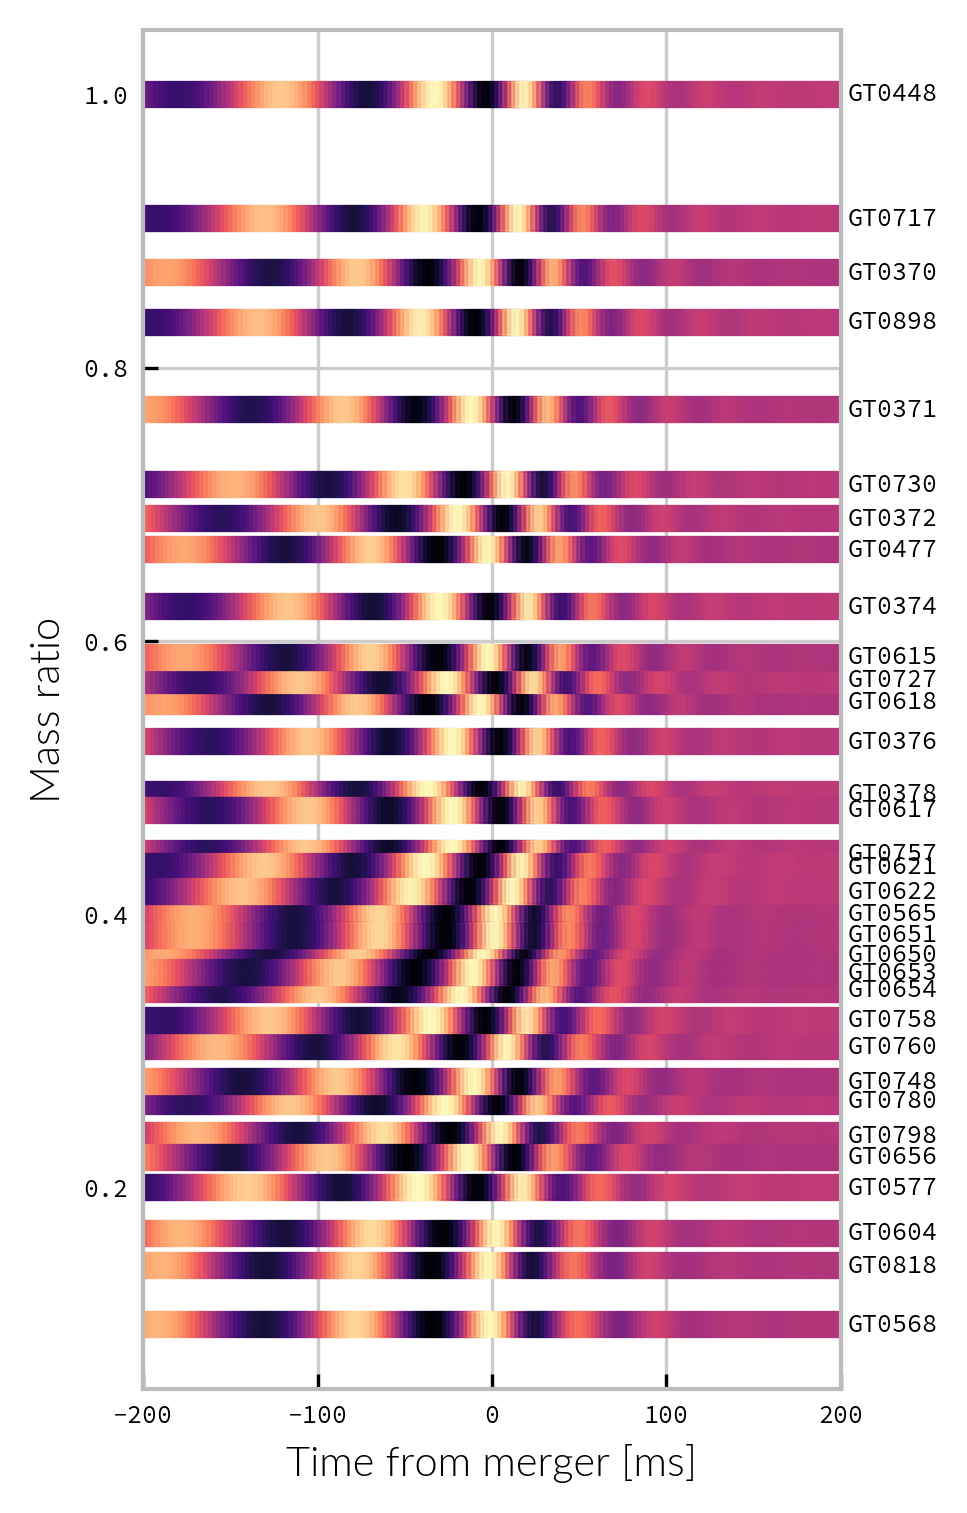

In [86]:
f, ax = plt.subplots(1,1, figsize=(3,6), dpi=300)
for waveform in query_waveforms:
    ts = waveform.timeseries(60, flow=50, coa_phase=np.pi/2.)[0]
    ax.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), 
               c = ts.data, marker=',', alpha=0.6)
    ax.set_xlim([-200, 200])
    ax.text(x=204, y=waveform.mass_ratio-0.005, s=waveform.tag, fontdict=ssp_ticks)
    
    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
        
    ax.set_xlabel("Time from merger [ms]", fontdict=lato)
    ax.set_ylabel("Mass ratio", fontdict=lato)

In [102]:
from elk import catalogue

In [119]:
import elk.exceptions

In [155]:
query = "  spin_1x < 0.001 & spin_1y < 0.001 & spin_1z < 0.001"\
        "& spin_2x < 0.001 & spin_2y < 0.001 & spin_2z < 0.001"

In [156]:
sxs_catalogue = catalogue.NRCatalogue(origin="SXS")
sxs_query_table = sxs_catalogue.table.query(query)
sxs_query_waveforms = [waveform for waveform in sxs_catalogue.waveforms if waveform.tag in list(sxs_query_table['tag'])]

In [157]:
gt_catalogue = catalogue.NRCatalogue(origin="GeorgiaTech")
gt_query_table = gt_catalogue.table.query(query)
gt_query_waveforms = [waveform for waveform in gt_catalogue.waveforms if waveform.tag in list(gt_query_table['tag'])]

In [ ]:
for waveform in sxs_query_waveforms:
    #if waveform.tag[-1] != "3": continue
    try:
        ts = waveform.timeseries(60, flow=50, coa_phase=np.pi/2)[0]
    except elk.exceptions.LalsuiteError:
        continue
    ax.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), 
               c = ts.data, marker=',', alpha=0.1, cmap='magma')
    ax.set_xlim([-200, 200])
    ax.text(x=204, y=waveform.mass_ratio-0.005, s=waveform.tag, fontdict=ssp_ticks)

Text(-100,0.9,'spin 1x = 0\nspin 1y = 0\nspin 1z = 0\nspin 2x = 0\nspin 2y = 0\nmass ratio = 1')

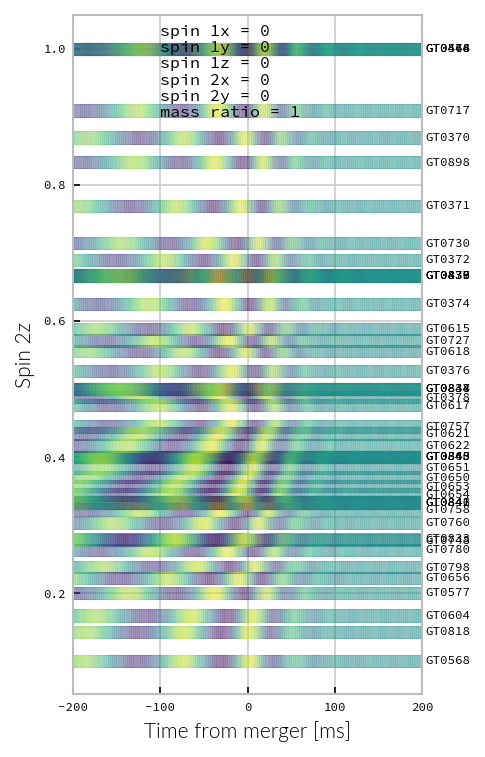

In [162]:
f, ax = plt.subplots(1,1, figsize=(3,6), dpi=150)

    
for waveform in gt_query_waveforms:
    #print waveform.tag
    try:
        ts = waveform.timeseries(60, flow=50)[0]
    except elk.exceptions.LalsuiteError:
        continue
    ax.scatter(x = ts.times*1e4, y= waveform.mass_ratio*np.ones(len(ts.times)), 
               c = ts.data, marker=',', alpha=0.1, cmap='viridis')
    ax.set_xlim([-200, 200])
    ax.text(x=204, y=waveform.mass_ratio-0.005, s=waveform.tag, fontdict=ssp_ticks)

    for label in ax.get_xticklabels():
        label.set_fontproperties(ticks_font)

    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)
        
    ax.set_xlabel("Time from merger [ms]", fontdict=lato)
    ax.set_ylabel("Spin 2z", fontdict=lato)
    
ax.text(x=-100, y=0.9, s="spin 1x = 0\nspin 1y = 0\nspin 1z = 0\nspin 2x = 0\nspin 2y = 0\nmass ratio = 1", fontdict=ssp_legend)